## Model's prediction
We create some synthetic data, in which we sparsely sample some regions and do not sample some intervals in our training set. We then evaluate the model's performance in predicting richly sampled, poorly sampled, and unsampled regions. We also examine its skill for extrapolation. 

In [1]:
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np

%matplotlib inline
import numpy as np

In [2]:
# Generate mock data
n = 10000  # Total number of samples
x = torch.linspace(-1, 1, n).unsqueeze(1)  # x uniformly sampled between -1 and 1

def function_y(x_c):
    n_c = x_c.shape[0]
    epsilon = 0.1 * torch.randn(n_c, 1) 
    y_c =(x_c)* torch.sin(x_c * 2 * np.pi)  # y = sin(2pi * x) + noise
    y_c_noise = y_c + epsilon
    return y_c_noise, y_c
y , _ = function_y(x)
# Define conditions for selective sampling
keep_condition = (x < -0.3) | (x > 0.)  # Condition to keep all data
thin_condition = (x >= -0.3) & (x <= 0.)  # Condition to thin data

# Randomly select a fraction of samples to keep for thinning
random_select = torch.rand(n, 1) < 0.2  # 20% chance to keep the sample
thin_samples = thin_condition & random_select

# Combine conditions to get the final selection
final_selection = keep_condition | thin_samples

# Apply the final selection to both x and y
x_selected = x[final_selection.squeeze()]
y_selected = y[final_selection.squeeze()]
condition = (x_selected < -0.16) | (x_selected > -0.15)

# Apply the condition to both x and y
train_x = x_selected[condition].view(-1, 1)
train_y = y_selected[condition].view(-1, 1)

Text(0, 0.5, 'y')

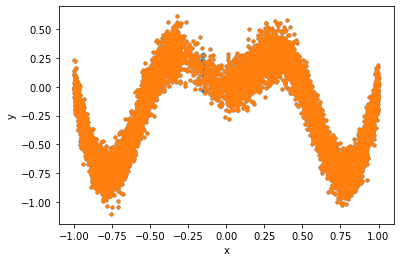

In [3]:
# Plot data 
plt.plot(x_selected[:,0], y_selected,'.')

plt.plot(train_x[:,0], train_y,'.')


plt.xlabel('x')
plt.ylabel('y')

In [4]:
# create a neural network
import torch.nn.init as init
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(1, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()


    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x

In [5]:
learning_rate = 0.005
loss_fn = torch.nn.MSELoss()

In [16]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(train_x)
    loss = loss_fn(pred, train_y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

def loopover_epoch(model, trainee = train_step,epochs = 1000 ):
    
    Loss = np.zeros(epochs)
    for t in range(epochs):
        optimizer = torch.optim.Adam(model.parameters())
        Loss[t] = trainee(model, loss_fn, optimizer)
    return Loss

In [97]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.
x_test = torch.linspace(-1.5, 1.5, 1001).reshape(1001, 1)
_, y_plot =function_y(x_test)
# Generate the predictions from the trained model.


def train_n_ensemble(n_ensemble = 1):
    # n conrols how many time the model will be trained. 
    # for deep ensemble set it to a large value (> 30)
    #otherwise keep it one
    
    pred = []
    for case in range(n_ensemble):
        neural_net = Simple_Neural_Net()
        Loss = loopover_epoch(neural_net,train_step)
        pred.append(neural_net(x_test).detach().numpy())
    return pred
pred = train_n_ensemble(4)

Text(0, 0.5, 'Y')

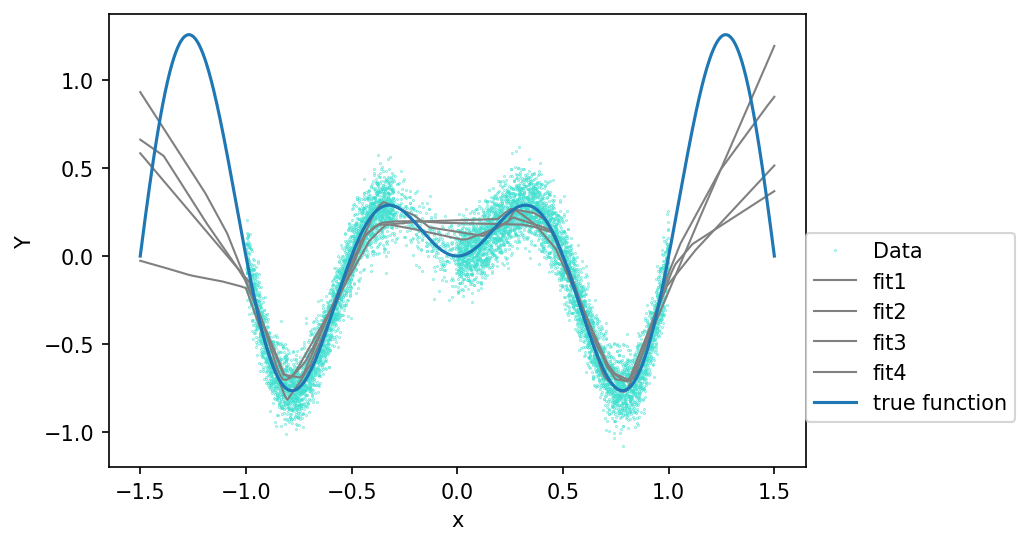

In [74]:
plt.figure(dpi=150)

plt.plot(train_x, train_y, ".", markersize=0.5, label="Data", color = 'turquoise')
for case in range(4):
    plt.plot(x_test, pred[case], markersize=0.5, label="fit" + str(case +1),color = 'gray' , linewidth = 1)
plt.plot(x_test, y_plot, markersize=0.5, label="true function")

plt.legend(loc = (1,0.1))
plt.xlabel('x')
plt.ylabel('Y')

In [77]:
#Deep Ensemble
# pred = train_n_ensemble(100)

In [ ]:
mean_profile = np.mean(pred, axis=0)
std_deviation = np.std(pred, axis=0)
print (pred.shape,mean_profile.shape, x_test.shape)
# Feature indices (x-axis)
features = np.arange(pred.shape[1])

# Plotting
plt.figure(figsize=(10, 6))

# Mean profile
plt.plot(x_test[:,0], mean_profile, label='Mean fits', color = 'gray')
plt.plot(train_x, train_y, ".", markersize=0.5, label="Data", color = 'turquoise', alpha = 0.4)
# Shade ±std
plt.fill_between(x_test[:,0], mean_profile - std_deviation, mean_profile + std_deviation, alpha=0.4, label='±1 Std. Dev. fits')


plt.plot(x_test, y_plot, markersize=0.5, label="true function")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean of fits with ±1 Standard Deviation')
plt.legend()

plt.show()

## MC dropout

In [116]:
import torch.nn.functional as F

class Dropout_Neural_Net(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.Dense1 = nn.Linear(1, 30)
        self.Dropout1 = nn.Dropout(dropout_rate)
        self.Dense2 = nn.Linear(30, 30)
        self.Dropout2 = nn.Dropout(dropout_rate)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x, apply_dropout=False):
        x = self.Dense1(x)
        x = self.relu(x)
        if apply_dropout:
            x = self.Dropout1(x)
        x = self.Dense2(x)
        x = self.relu(x)
        if apply_dropout:
            x = self.Dropout2(x)
        x = self.Dense3(x)
        return x

    def predict_with_uncertainty(self, x, n_samples=1000): 
        ## sample 100 models with dropout
        self.train()  # Enable dropout
        predictions = torch.zeros([n_samples, x.size(0), 1])
        for i in range(n_samples):
            predictions[i] = self.forward(x, apply_dropout=True)
        mean_predictions = predictions.mean(0)
        std_predictions = predictions.std(0)
        return mean_predictions, std_predictions

In [117]:
def train_n_ensemble(n_ensemble = 1):
    # n conrols how many time the model will be trained. 
    # for deep ensemble set it to a large value (> 30)
    #otherwise keep it one
    
    pred = []
    for case in range(n_ensemble):
        neural_net = Dropout_Neural_Net()
        Loss = loopover_epoch(neural_net,trainee)
        pred.append(neural_net.predict_with_uncertainty(x_test))
    return pred
pred= train_n_ensemble(1)

In [119]:
mean_profile, std_deviation = pred[0]
mean_profile = mean_profile.detach().numpy()
std_deviation = std_deviation.detach().numpy()
std_deviation.shape

(1001, 1)

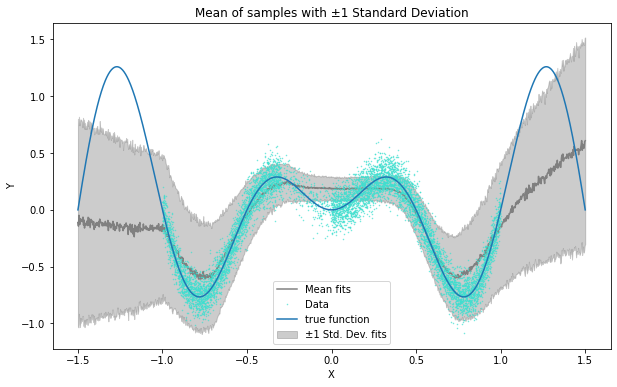

In [127]:
# Plotting
fig = plt.figure(figsize=(10, 6))

# Mean profile
plt.plot(x_test[:,0], mean_profile[:,0], label='Mean fits', color = 'gray')
plt.plot(train_x, train_y, ".", markersize=1, label="Data", color = 'turquoise', alpha = 0.8)
# Shade ±std
plt.fill_between(x_test[:,0], mean_profile[:,0] - std_deviation[:,0],
                 mean_profile[:,0] + std_deviation[:,0], alpha=0.4, label='±1 Std. Dev. fits'
                ,color = 'gray')


plt.plot(x_test, y_plot, markersize=0.5, label="true function")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean of samples with ±1 Standard Deviation')
plt.legend()

plt.show()
fig.savefig('dropout.jpeg',bbox_inches = 'tight', dpi = 100)

## probabilistic loss: predicting both mean and std

In [7]:
class Neural_Net_With_Uncertainty(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(1, 30)
        self.Dense2 = nn.Linear(30, 30)
        # Output layer now has 2 units: one for mean, one for log(std)
        self.Dense3 = nn.Linear(30, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)
        # Ensure the standard deviation is positive
        # The second output uses softplus to ensure positivity (representing log(std))
        mean, log_std = x[:, 0], x[:, 1]
        std = torch.exp(log_std)  # Convert log(std) to std
        return mean, std

def log_likelihood_loss(y_pred_mean, y_pred_std, y_true):
    """
    Calculate the negative log likelihood loss assuming Gaussian distribution of errors.
    """
    # Ensure std is positive
    y_pred_std = torch.exp(y_pred_std)
    # Gaussian log likelihood
    loss = torch.log(y_pred_std) + 0.5 * ((y_true - y_pred_mean) / y_pred_std) ** 2
    return torch.mean(loss)

In [129]:
# we need to define a new train function that applies our new loss:

In [ ]:
x_test = torch.linspace(-1.5, 1.5, 1001).reshape(1001, 1)
_, y_plot =function_y(x_test)
def train_step_log_like(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    
    mean, std = model(train_x)
    loss = log_likelihood_loss(mean, std, train_y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss
def train_n_ensemble(n_ensemble = 1):
    # n_ensemble conrols how many time the model will be trained. 
    # for deep ensemble set it to a large value (> 30)
    #otherwise keep it one
    
    pred = []
    for case in range(n_ensemble):
        neural_net = Neural_Net_With_Uncertainty()
        Loss = loopover_epoch(neural_net, train_step_log_like)
        pred.append(neural_net(x_test))
    return pred
pred= train_n_ensemble(1)

In [14]:
mean_profile, std_deviation = pred[0]
mean_profile = mean_profile.detach().numpy()
std_deviation = std_deviation.detach().numpy()

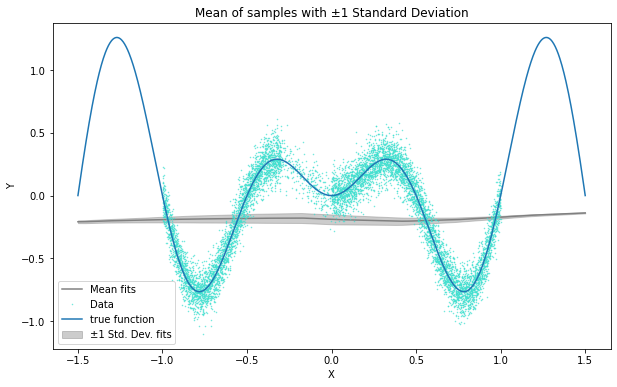

In [17]:
# Plotting
fig = plt.figure(figsize=(10, 6))

# Mean profile
plt.plot(x_test[:,0], mean_profile, label='Mean fits', color = 'gray')
plt.plot(train_x, train_y, ".", markersize=1, label="Data", color = 'turquoise', alpha = 0.8)
# Shade ±std
plt.fill_between(x_test[:,0], mean_profile - std_deviation,
                 mean_profile + std_deviation, alpha=0.4, label='±1 Std. Dev. fits'
                ,color = 'gray')


plt.plot(x_test, y_plot, markersize=0.5, label="true function")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean of samples with ±1 Standard Deviation')
plt.legend()

plt.show()
fig.savefig('dropout.jpeg',bbox_inches = 'tight', dpi = 100)